# Building your first Artificial Neural Network with AWS

#### Predicting fashion type using Zalando's Fasion-MNIST dataset (https://github.com/zalandoresearch/fashion-mnist)

***
Copyright [2017]-[2017] Amazon.com, Inc. or its affiliates. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"). You may not use this file except in compliance with the License. A copy of the License is located at

http://aws.amazon.com/apache2.0/

or in the "license" file accompanying this file. This file is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.
***

### Load dependencies

In [20]:
import mxnet as mx
import mxnet.notebook.callback
import numpy as np
import os
import urllib
import gzip
import struct
import math
import cv2
import scipy.misc
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

### Prepare training and test datasets

In [21]:
def download_data(url, force_download=True): 
    fname = url.split("/")[-1]
    if force_download or not os.path.exists(fname):
        urllib.urlretrieve(url, fname)
    return fname

def to4d(img):
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32)/255

def read_data(label, image):
    base_url = 'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/'
    with gzip.open(download_data(base_url+label, os.path.join('data',label))) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(download_data(base_url+image, os.path.join('data',image)), 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

batch_size = 100
(train_lbl, train_img) = read_data('train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz')
(val_lbl, val_img) = read_data('t10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz')
train_data_iter = mx.io.NDArrayIter(data={'fashion_data': to4d(train_img)}, label= {'fashion_item_label': train_lbl}, batch_size=100, shuffle=True)
test_data_iter = mx.io.NDArrayIter(data={'fashion_data': to4d(val_img)}, label= {'fashion_item_label': val_lbl}, batch_size=100)

### Display example training data

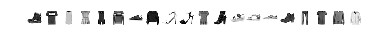

label: [9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4]


In [24]:
for i in range(20):
    plt.subplot(1,20,i+1)
    dsp_img= cv2.bitwise_not(train_img[i])
    plt.imshow(dsp_img, cmap='Greys_r')
    plt.axis('off')

plt.show()
print('label: %s' % (train_lbl[0:20],))


In [25]:
# Zalando fashion labels https://github.com/zalandoresearch/fashion-mnist

fashion_labels=['T-shirt/top',
'Trouser',
'Pullover',
'Dress',
'Coat',
'Sandal',
'Shirt',
'Sneaker',
'Bag',
'Ankle boot']

### Build MXNet model

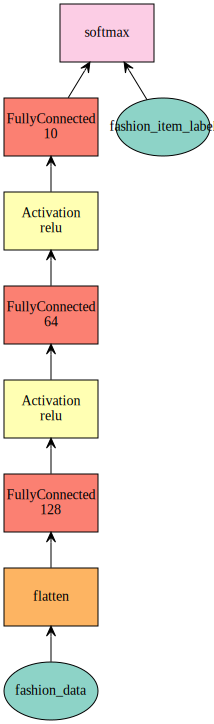

In [26]:
fashion_item_label = mx.symbol.Variable('fashion_item_label')
# input
data = mx.symbol.Variable('fashion_data')
# Flatten the data from 4-D shape into 2-D (batch_size, num_channel*width*height)
data = mx.sym.flatten(data=data, name='flatten')

# 1st fully-connected layer + activation function
fc1  = mx.sym.FullyConnected(data=data, num_hidden=128)
act1 = mx.sym.Activation(data=fc1, act_type="relu")
# 2nd fully-connected layer + activation function
fc2  = mx.sym.FullyConnected(data=act1, num_hidden = 64)
act2 = mx.sym.Activation(data=fc2, act_type="relu")
# 3rd fully connected layer (MNIST uses 10 classes)
fc3  = mx.sym.FullyConnected(data=act2, num_hidden=10)
# softmax with cross entropy loss
mlp  = mx.sym.SoftmaxOutput(data = fc3, label = fashion_item_label, name='softmax')

mx.viz.plot_network(mlp)

### Train the model and commit checkpoints

In [27]:
import logging

logging.basicConfig(level=logging.INFO)
logging.getLogger().setLevel(logging.INFO)

ctx = mx.cpu()

mod = mx.mod.Module(symbol=mlp, data_names=['fashion_data'], label_names=['fashion_item_label'], context=ctx, logger=logging)
mod.bind(data_shapes=train_data_iter.provide_data, label_shapes=train_data_iter.provide_label)
mod.init_params(initializer=mx.init.Xavier(magnitude=2.))
                        
mod.fit(train_data_iter,                            # train data
        eval_data=test_data_iter,                   # validation data
        optimizer='sgd',                            # use SGD to train
        optimizer_params={'learning_rate' : 0.1},   # use fixed learning rate
        eval_metric=mx.metric.Accuracy(),           # report accuracy during training
        num_epoch=10,                               # train for at most 10 dataset passes
        epoch_end_callback = mx.callback.do_checkpoint('fashion_mnist')) 

INFO:root:Epoch[0] Train-accuracy=0.764150
INFO:root:Epoch[0] Time cost=1.442
INFO:root:Saved checkpoint to "fashion_mnist-0001.params"
INFO:root:Epoch[0] Validation-accuracy=0.817200
INFO:root:Epoch[1] Train-accuracy=0.840433
INFO:root:Epoch[1] Time cost=1.434
INFO:root:Saved checkpoint to "fashion_mnist-0002.params"
INFO:root:Epoch[1] Validation-accuracy=0.833300
INFO:root:Epoch[2] Train-accuracy=0.855867
INFO:root:Epoch[2] Time cost=1.598
INFO:root:Saved checkpoint to "fashion_mnist-0003.params"
INFO:root:Epoch[2] Validation-accuracy=0.846900
INFO:root:Epoch[3] Train-accuracy=0.865417
INFO:root:Epoch[3] Time cost=1.441
INFO:root:Saved checkpoint to "fashion_mnist-0004.params"
INFO:root:Epoch[3] Validation-accuracy=0.854300
INFO:root:Epoch[4] Train-accuracy=0.872783
INFO:root:Epoch[4] Time cost=1.438
INFO:root:Saved checkpoint to "fashion_mnist-0005.params"
INFO:root:Epoch[4] Validation-accuracy=0.863400
INFO:root:Epoch[5] Train-accuracy=0.877700
INFO:root:Epoch[5] Time cost=1.441
IN

### Run predictions for 10 example elements

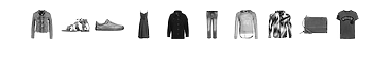

Predicted fashion label for image 10 is [4]  
Predicted fashion label for image 11 is [5]  
Predicted fashion label for image 12 is [5]  
Predicted fashion label for image 13 is [3]  
Predicted fashion label for image 14 is [4]  
Predicted fashion label for image 15 is [1]  
Predicted fashion label for image 16 is [2]  
Predicted fashion label for image 17 is [2]  
Predicted fashion label for image 18 is [8]  
Predicted fashion label for image 19 is [0]  


In [28]:
pred_data_iter = mx.io.NDArrayIter(data={'fashion_data': to4d(val_img)[0:100]}, batch_size=100)
pred_digits = mod.predict(eval_data=pred_data_iter).asnumpy()

%matplotlib inline
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(val_img[i + 10], cmap='Greys')
    plt.axis('off')
plt.show()

for x in range(10, 20):
    print("Predicted fashion label for image %s is %s  " % (x, np.where(pred_digits[x,0:10] == pred_digits[x,0:10].max())[0]))

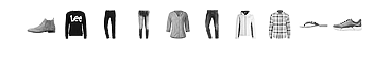

Predicted fashion label for image 0 is [9]  
Predicted fashion label for image 1 is [2]  
Predicted fashion label for image 2 is [1]  
Predicted fashion label for image 3 is [1]  
Predicted fashion label for image 4 is [6]  
Predicted fashion label for image 5 is [1]  
Predicted fashion label for image 6 is [4]  
Predicted fashion label for image 7 is [6]  
Predicted fashion label for image 8 is [5]  
Predicted fashion label for image 9 is [7]  


In [29]:
%matplotlib inline
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(val_img[i], cmap='Greys')
    plt.axis('off')
plt.show()

for x in range(0, 10):
    print("Predicted fashion label for image %s is %s  " % (x, np.where(pred_digits[x,0:10] == pred_digits[x,0:10].max())[0]))

### Downloading images for prediction from amazon.com

In [30]:
!wget -O predict1.jpg https://images-na.ssl-images-amazon.com/images/I/81OaXwn1x4L._UX679_.jpg
!wget -O predict2.jpg https://images-eu.ssl-images-amazon.com/images/I/31TcgNHsbIL._AC_UL260_SR200,260_.jpg
!wget -O predict3.jpg https://images-eu.ssl-images-amazon.com/images/I/41hWhZBIc3L._AC_UL260_SR200,260_.jpg


--2017-12-18 13:37:20--  https://images-na.ssl-images-amazon.com/images/I/81OaXwn1x4L._UX679_.jpg
Resolving images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)... 54.230.28.186
Connecting to images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)|54.230.28.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35308 (34K) [image/jpeg]
Saving to: ‘predict1.jpg’

predict1.jpg        100%[===================>]  34.48K  --.-KB/s    in 0s      

2017-12-18 13:37:20 (78.3 MB/s) - ‘predict1.jpg’ saved [35308/35308]

--2017-12-18 13:37:20--  https://images-eu.ssl-images-amazon.com/images/I/31TcgNHsbIL._AC_UL260_SR200,260_.jpg
Resolving images-eu.ssl-images-amazon.com (images-eu.ssl-images-amazon.com)... 54.230.28.186
Connecting to images-eu.ssl-images-amazon.com (images-eu.ssl-images-amazon.com)|54.230.28.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7302 (7.1K) [image/jpeg]
Saving to: ‘predict2.jpg’

predict2.jpg  

### Load model from checkpoint for prediction

In [31]:
prediction_model_check_point = 10
prediction_model_prefix = 'fashion_mnist'
prediction_sym, arg_params, aux_params = mx.model.load_checkpoint(prediction_model_prefix, prediction_model_check_point)
prediction_model = mx.mod.Module(symbol=prediction_sym, data_names=['fashion_data'], label_names=['fashion_item_label'])
prediction_model.bind(for_training=False, data_shapes=[('fashion_data', (1,1,28,28))])
prediction_model.set_params(arg_params=arg_params, aux_params=aux_params, allow_missing=True)

# define prediction function
def predict_fashion(img):
    # format data to run prediction
    array = np.full((1, 28, 28), img, dtype=np.float32)
    array.shape
    pred_data_iter = mx.io.NDArrayIter(data={'fashion_data': to4d(array)}, batch_size=1)
    
    pred_digits = prediction_model.predict(eval_data=pred_data_iter).asnumpy()

    label = (np.where(pred_digits[0] == pred_digits[0].max())[0])
    
    print("Predicted fashion label for image is %s (%s)  " % (label,fashion_labels[label[0]]))


### Predict labels for downloaded images

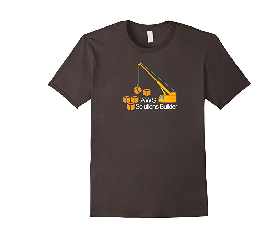

Predicted fashion label for image is [0] (T-shirt/top)  


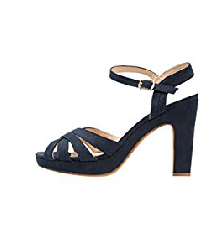

Predicted fashion label for image is [5] (Sandal)  


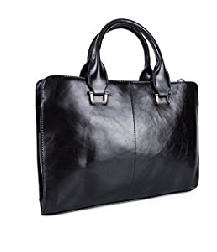

Predicted fashion label for image is [8] (Bag)  


In [32]:
for i in xrange(3):
        img = mpimg.imread('predict'+str(i+1)+'.jpg')
        plt.imshow(img)
        plt.axis('off')
        plt.show() 
        # get colours in line with train data
        img  = cv2.bitwise_not(img)
        img= np.array (np.mean(img, -1))

        # resize image
        img = scipy.misc.imresize(img, (28, 28))


        predict_fashion(img)

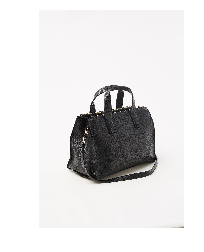

Predicted fashion label for image is [8] (Bag)  


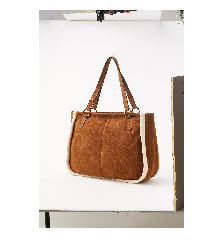

Predicted fashion label for image is [8] (Bag)  


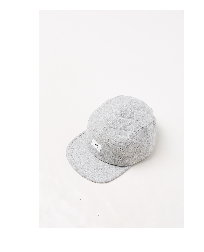

Predicted fashion label for image is [5] (Sandal)  


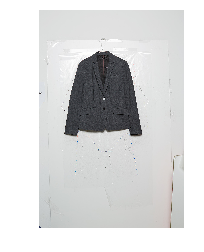

Predicted fashion label for image is [8] (Bag)  


In [33]:
for i in range(4):
    img = mpimg.imread('porta' + str(i + 1) + '.jpg')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    # get colours in line with train data
    img = cv2.bitwise_not(img)
    img = np.array (np.mean(img, -1))
    # resize image
    img = scipy.misc.imresize(img, (28, 28))
    predict_fashion(img)
